<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

***Some parts of the notebook are almost the copy of [ mmta-team course](https://github.com/mmta-team/mmta_fall_2020). Special thanks to mmta-team for making them publicly available. [Original notebook](https://github.com/mmta-team/mmta_fall_2020/blob/master/tasks/01_word_embeddings/task_word_embeddings.ipynb).***

<b> Прочитайте семинар, пожалуйста, для успешного выполнения домашнего задания. В конце ноутка напишите свой вывод. Работа без вывода оценивается ниже.

## Задача поиска схожих по смыслу предложений

Мы будем ранжировать вопросы [StackOverflow](https://stackoverflow.com) на основе семантического векторного представления 

До этого в курсе не было речи про задачу ранжировния, поэтому введем математическую формулировку

## Задача ранжирования(Learning to Rank)

* $X$ - множество объектов
* $X^l = \{x_1, x_2, ..., x_l\}$ - обучающая выборка
<br>На обучающей выборке задан порядок между некоторыми элементами, то есть нам известно, что некий объект выборки более релевантный для нас, чем другой:
* $i \prec j$ - порядок пары индексов объектов на выборке $X^l$ c индексами $i$ и $j$
### Задача:
построить ранжирующую функцию $a$ : $X \rightarrow R$ такую, что
$$i \prec j \Rightarrow a(x_i) < a(x_j)$$

<img src="https://d25skit2l41vkl.cloudfront.net/wp-content/uploads/2016/12/Featured-Image.jpg" width=500, height=450>

### Embeddings

Будем использовать предобученные векторные представления слов на постах Stack Overflow.<br>
[A word2vec model trained on Stack Overflow posts](https://github.com/vefstathiou/SO_word2vec)

In [ ]:
!wget https://zenodo.org/record/1199620/files/SO_vectors_200.bin?download=1

--2021-02-25 20:47:25--  https://zenodo.org/record/1199620/files/SO_vectors_200.bin?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1453905423 (1.4G) [application/octet-stream]
Saving to: ‘SO_vectors_200.bin?download=1.1’

SO_vectors_200.bin? 100%[===================>]   1.35G  6.46MB/s    in 2m 35s  

2021-02-25 20:50:01 (8.96 MB/s) - ‘SO_vectors_200.bin?download=1.1’ saved [1453905423/1453905423]



In [ ]:
from gensim.models.keyedvectors import KeyedVectors
wv_embeddings = KeyedVectors.load_word2vec_format("SO_vectors_200.bin?download=1", binary=True)

#### Как пользоваться этими векторами?

Посмотрим на примере одного слова, что из себя представляет embedding

In [ ]:
word = 'dog'
if word in wv_embeddings:
    print(wv_embeddings[word].dtype, wv_embeddings[word].shape)

float32 (200,)


In [ ]:
print(f"Num of words: {len(wv_embeddings.index2word)}")

Num of words: 1787145


Найдем наиболее близкие слова к слову `dog`:

#### Вопрос 1:
* Входит ли слов `cat` топ-5 близких слов к слову `dog`? Какое место? 

In [ ]:
# method most_simmilar
wv_embeddings.most_similar(positive=['dog'], topn=5) # 

[('animal', 0.8564180135726929),
 ('dogs', 0.7880867123603821),
 ('mammal', 0.7623804807662964),
 ('cats', 0.7621253728866577),
 ('animals', 0.760793924331665)]

### Векторные представления текста

Перейдем от векторных представлений отдельных слов к векторным представлениям вопросов, как к **среднему** векторов всех слов в вопросе. Если для какого-то слова нет предобученного вектора, то его нужно пропустить. Если вопрос не содержит ни одного известного слова, то нужно вернуть нулевой вектор.

In [ ]:
import numpy as np
import re
from nltk.tokenize import WordPunctTokenizer
# you can use your tokenizer
# for example, from nltk.tokenize import WordPunctTokenizer
class MyTokenizer:
    def __init__(self):
        pass
    def tokenize(self, text):
        return re.findall('\w+', text)
from nltk.tokenize import RegexpTokenizer
tokenizer_v1 = WordPunctTokenizer()
tokenizer_v2 = RegexpTokenizer(r'\w+')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def question_to_vec(question, embeddings, tokenizer, dim=200):
    """
        question: строка
        embeddings: наше векторное представление
        dim: размер любого вектора в нашем представлении
        
        return: векторное представление для вопроса
    """
    z = np.zeros(dim)
    count = 0
    tokenize_string = tokenizer.tokenize(question)
    for i in range(len(tokenize_string)):
      if tokenize_string[i] in embeddings:
        z += embeddings.get_vector(tokenize_string[i])
        count += 1
        # z.append(wv_embeddings.get_vector(tokenize_string[i]))
    # s = np.zeros(200)
    # for i in range(len(sum)):
    #   s += sum[i]
    if count != 0:
        z = z / count
    return z #s/len(sum) #np.average(sum, axis=1)
    '''your code'''

Теперь у нас есть метод для создания векторного представления любого предложения.

#### Вопрос 2:
* Какая третья(с индексом 2) компонента вектора предложения `I love neural networks` (округлите до 2 знаков после запятой)?

In [ ]:
Z = question_to_vec('I love neural networks', wv_embeddings, tokenizer_v1)
print(round(Z[2], 2))

-1.29


### Оценка близости текстов

Представим, что мы используем идеальные векторные представления слов. Тогда косинусное расстояние между дублирующими предложениями должно быть меньше, чем между случайно взятыми предложениями. 

Сгенерируем для каждого из $N$ вопросов $R$ случайных отрицательных примеров и примешаем к ним также настоящие дубликаты. Для каждого вопроса будем ранжировать с помощью нашей модели $R + 1$ примеров и смотреть на позицию дубликата. Мы хотим, чтобы дубликат был первым в ранжированном списке.

#### Hits@K
Первой простой метрикой будет количество корректных попаданий для какого-то $K$:
$$ \text{Hits@K} = \frac{1}{N}\sum_{i=1}^N \, [rank\_q_i^{'} \le K],$$
* $\begin{equation*}
[x < 0 ] \equiv 
 \begin{cases}
   1, &x < 0\\
   0, &x \geq 0
 \end{cases}
\end{equation*}$ - индикаторная функция
* $q_i$ - $i$-ый вопрос
* $q_i^{'}$ - его дубликат
* $rank\_q_i^{'}$ - позиция дубликата в ранжированном списке ближайших предложений для вопроса $q_i$.

#### DCG@K
Второй метрикой будет упрощенная DCG метрика, учитывающая порядок элементов в списке путем домножения релевантности элемента на вес равный обратному логарифму номера позиции::
$$ \text{DCG@K} = \frac{1}{N} \sum_{i=1}^N\frac{1}{\log_2(1+rank\_q_i^{'})}\cdot[rank\_q_i^{'} \le K],$$
С такой метрикой модель штрафуется за большой ранк корректного ответа

#### Вопрос 3:
* Максимум `Hits@47 - DCG@1`?

Максимум Hits@47 - DCG@1 = 1 - 0 = 1

<img src='https://hsto.org/files/1c5/edf/dee/1c5edfdeebce4b71a86bdf986d9f88f2.jpg' width=400, height=200>

#### Пример оценок

Вычислим описанные выше метрики для игрушечного примера. 
Пусть
* $N = 1$, $R = 3$
* <font color='green'>"Что такое python?"</font> - вопрос $q_1$
* <font color='red'>"Что такое язык python?"</font> - его дубликат $q_i^{'}$

Пусть модель выдала следующий ранжированный список кандидатов:

1. "Как изучить с++?"
2. <font color='red'>"Что такое язык python?"</font>
3. "Хочу учить Java"
4. "Не понимаю Tensorflow"

$\Rightarrow rank\_q_i^{'} = 2$

Вычислим метрику *Hits@K* для *K = 1, 4*:

- [K = 1] $\text{Hits@1} =  [rank\_q_i^{'} \le 1)] = 0$
- [K = 4] $\text{Hits@4} =  [rank\_q_i^{'} \le 4] = 1$

Вычислим метрику *DCG@K* для *K = 1, 4*:
- [K = 1] $\text{DCG@1} = \frac{1}{\log_2(1+2)}\cdot[2 \le 1] = 0$
- [K = 4] $\text{DCG@4} = \frac{1}{\log_2(1+2)}\cdot[2 \le 4] = \frac{1}{\log_2{3}}$

#### Вопрос 4:
* Вычислите `DCG@10`, если $rank\_q_i^{'} = 9$(округлите до одного знака после запятой)

In [ ]:
import math
DCG = 1/math.log(1 + 9, 2)
print(round(DCG, 1))

0.3


### HITS\_COUNT и DCG\_SCORE

Каждая функция имеет два аргумента: $dup\_ranks$ и $k$. $dup\_ranks$ является списком, который содержит рейтинги дубликатов(их позиции в ранжированном списке). Например, $dup\_ranks = [2]$ для примера, описанного выше.

In [ ]:
def hits_count(dup_ranks, k):
    """
        dup_ranks: list индексов дубликатов
        result: вернуть  Hits@k
    """
    N = len(dup_ranks)
    sum = 0
    for i in range(N):
        x = dup_ranks[i] <= k
        sum += int(x)
    hits_value = sum / N
    # v_rngs = (dup_ranks <= k).int()
    # hits_value = mean(v_rngs)
    return hits_value    

In [ ]:
def dcg_score(dup_ranks, k):
    """
        dup_ranks: list индексов дубликатов
        result: вернуть DCG@k
    """
    N = len(dup_ranks)
    sum = 0
    for i in range(N):
        x = int((dup_ranks[i] <= k))
        sum += x/math.log(1 + dup_ranks[i], 2)
    dcg_value = sum / N
    return dcg_value

Протестируем функции. Пусть $N = 1$, то есть один эксперимент. Будем искать копию вопроса и оценивать метрики.

In [ ]:
import pandas as pd

In [ ]:
copy_answers = ["How does the catch keyword determine the type of exception that was thrown",]

# наги кандидаты
candidates_ranking = [["How Can I Make These Links Rotate in PHP",
                       "How does the catch keyword determine the type of exception that was thrown",
                       "NSLog array description not memory address",
                       "PECL_HTTP not recognised php ubuntu"],]
# dup_ranks — позиции наших копий, так как эксперимент один, то этот массив длины 1
dup_ranks = [2]

# вычисляем метрику для разных k
print('Ваш ответ HIT:', [hits_count(dup_ranks, k) for k in range(1, 5)])
print('Ваш ответ DCG:', [round(dcg_score(dup_ranks, k), 5) for k in range(1, 5)])

Ваш ответ HIT: [0.0, 1.0, 1.0, 1.0]
Ваш ответ DCG: [0.0, 0.63093, 0.63093, 0.63093]


У вас должно получиться

In [ ]:
# correct_answers - метрика для разных k
correct_answers = pd.DataFrame([[0, 1, 1, 1], [0, 1 / (np.log2(3)), 1 / (np.log2(3)), 1 / (np.log2(3))]],
                               index=['HITS', 'DCG'], columns=range(1,5))
correct_answers

,1,2,3,4
HITS,0,1.00000,1.00000,1.00000
DCG,0,0.63093,0.63093,0.63093


### Данные
[arxiv link](https://drive.google.com/file/d/1QqT4D0EoqJTy7v9VrNCYD-m964XZFR7_/edit)

`train.tsv` - выборка для обучения.<br> В каждой строке через табуляцию записаны: **<вопрос>, <похожий вопрос>**

`validation.tsv` - тестовая выборка.<br> В каждой строке через табуляцию записаны: **<вопрос>, <похожий вопрос>, <отрицательный пример 1>, <отрицательный пример 2>, ...**

In [ ]:
!unzip stackoverflow_similar_questions.zip

Archive:  stackoverflow_similar_questions.zip
replace data/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Считайте данные.

In [ ]:
!pip install -q pymorphy2
import spacy
nlp = spacy.load('en_core_web_sm')
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def read_corpus(filename):
    data = []
    for line in open(filename, encoding='utf-8'):
        data.append(line.strip().split('\t'))
    return data

Нам понадобиться только файл validation.

In [ ]:
validation_data = read_corpus('./data/validation.tsv')

In [ ]:
validation_data[1]

Кол-во строк

In [ ]:
len(validation_data)

3760

Размер нескольких первых строк

In [ ]:
for i in range(5):
    print(i + 1, len(validation_data[i]))

1 1001
2 1001
3 1001
4 1001
5 1001


### Ранжирование без обучения

Реализуйте функцию ранжирования кандидатов на основе косинусного расстояния. Функция должна по списку кандидатов вернуть отсортированный список пар (позиция в исходном списке кандидатов, кандидат). При этом позиция кандидата в полученном списке является его рейтингом (первый - лучший). Например, если исходный список кандидатов был [a, b, c], и самый похожий на исходный вопрос среди них - c, затем a, и в конце b, то функция должна вернуть список **[(2, c), (0, a), (1, b)]**.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from copy import deepcopy

In [ ]:
def rank_candidates(question, candidates, embeddings, tokenizer, dim=200):
    """
        question: строка
        candidates: массив строк(кандидатов) [a, b, c]
        result: пары (начальная позиция, кандидат) [(2, c), (0, a), (1, b)]
    """
    '''your code'''
    tmp_res = []
    que_vec = question_to_vec(question.lower(), embeddings, tokenizer, dim)
    for i in range(len(candidates)):
        can_vec = question_to_vec(candidates[i].lower(), embeddings, tokenizer, dim)
        cos_sim = cosine_similarity([que_vec], [can_vec])[0]
        e = [cos_sim[0], i]
        tmp_res.append(e)
    tmp_res.sort(key=lambda x: -x[0])
    result = []
    for i in range(len(tmp_res)):
        num = tmp_res[i][1]
        x = (num, candidates[num])
        result.append(x)

    return result

Протестируйте работу функции на примерах ниже. Пусть $N=2$, то есть два эксперимента

In [ ]:
questions = ['converting string to list', 'Sending array via Ajax fails'] 

candidates = [['Convert Google results object (pure js) to Python object', # первый эксперимент
               'C# create cookie from string and send it',
               'How to use jQuery AJAX for an outside domain?'],
              
              ['Getting all list items of an unordered list in PHP',      # второй эксперимент
               'WPF- How to update the changes in list item of a list',
               'select2 not displaying search results']]

In [ ]:
for question, q_candidates in zip(questions, candidates):
        ranks = rank_candidates(question, q_candidates, wv_embeddings, tokenizer_v1)
        print(ranks)
        print()

[(1, 'C# create cookie from string and send it'), (0, 'Convert Google results object (pure js) to Python object'), (2, 'How to use jQuery AJAX for an outside domain?')]

[(0, 'Getting all list items of an unordered list in PHP'), (2, 'select2 not displaying search results'), (1, 'WPF- How to update the changes in list item of a list')]



Для первого экперимента вы можете полностью сравнить ваши ответы и правильные ответы. Но для второго эксперимента два ответа на кандидаты будут <b>скрыты</b>(*)

In [ ]:
# должно вывести
results = [[(1, 'C# create cookie from string and send it'),
            (0, 'Convert Google results object (pure js) to Python object'),
            (2, 'How to use jQuery AJAX for an outside domain?')],
           [(0, 'Getting all list items of an unordered list in PHP'), #скрыт
            (2, 'select2 not displaying search results'), #скрыт
            (1, 'WPF- How to update the changes in list item of a list')]] #скрыт

Последовательность начальных индексов вы должны получить `для эксперимента 1`  1, 0, 2.

#### Вопрос 5:
* Какую последовательность начальных индексов вы получили `для эксперимента 2`(перечисление без запятой и пробелов, например, `102` для первого эксперимента?

021

Теперь мы можем оценить качество нашего метода. Запустите следующие два блока кода для получения результата. Обратите внимание, что вычисление расстояния между векторами занимает некоторое время (примерно 10 минут). Можете взять для validation 1000 примеров.

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
wv_ranking = []
max_validation_examples = 1000
for i, line in enumerate(tqdm(validation_data)):
    if i == max_validation_examples:
        break
    q, *ex = line
    ranks = rank_candidates(q, ex, wv_embeddings, tokenizer_v2)
    wv_ranking.append([r[0] for r in ranks].index(0) + 1)

In [ ]:
for k in tqdm([1, 5, 10, 100, 500, 1000]):
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

DCG@   1: 0.415 | Hits@   1: 0.415
DCG@   5: 0.502 | Hits@   5: 0.582
DCG@  10: 0.525 | Hits@  10: 0.651
DCG@ 100: 0.570 | Hits@ 100: 0.874
DCG@ 500: 0.583 | Hits@ 500: 0.973
DCG@1000: 0.586 | Hits@1000: 1.000



### Эмбеддинги, обученные на корпусе похожих вопросов

In [ ]:
def read_date(filename):
    data = open(filename, encoding='utf-8')
    return data.read()

In [ ]:
train_data = read_corpus('./data/train.tsv')

Улучшите качество модели.<br>Склеим вопросы в пары и обучим на них модель Word2Vec из gensim. Выберите размер window. Объясните свой выбор.

In [ ]:
train_data = read_date('./data/train.tsv')

In [ ]:
def split_data(train_data):
    data = []
    for doc in nlp.pipe(train_data, batch_size=256, n_process=12, disable=["parser", "ner"]):
        data.append(' '.join([token.lemma_ for token in doc if token.lemma_ not in stopWords]))
    return data

In [ ]:
len(train_data)

1000000

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopWords = set(stopwords.words('english'))
nltk.download('wordnet')
wnl = nltk.WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def preproc_nltk(text):
    #text = re.sub(f'[{string.punctuation}]', ' ', text)
    data = []
    xx = 0
    for i in text:
        if xx > 1:
            break
        #data.append([wnl.lemmatize(word) for word in tokenizer.tokenize(i.lower()) if word not in stopWords])
        i = i.lower()
        # spacy_results = nlp(i)
        # print('spacy_results', spacy_results)
        g = ' '.join([word for word in tokenizer_v2.tokenize(i) if word not in stopWords])
        #print('g', g)
        data.append(g)
        xx += 1
    return data

In [ ]:
train_data[1]

['Which HTML 5 Canvas Javascript to use for making an interactive drawing tool?',
 'Event handling for geometries in Three.js?']

In [ ]:
words = [preproc_nltk(text) for text in train_data]

In [ ]:
words[1]

['html 5 canvas javascript use making interactive drawing tool',
 'event handling geometries three js']

In [ ]:
from gensim.models import Word2Vec
embeddings_trained = Word2Vec(words, # data for model to train on
                 size=200,                 # embedding vector size
                 min_count=3,             # consider words that occured at least 5 times
                 window=3).wv # достаточно близкие слова

In [ ]:
wv_ranking = []
max_validation_examples = 1000
for i, line in enumerate(tqdm(validation_data)):
    if i == max_validation_examples:
        break
    q, *ex = line
    ranks = rank_candidates(q, ex, embeddings_trained, tokenizer_v1)
    wv_ranking.append([r[0] for r in ranks].index(0) + 1)

In [ ]:
for k in tqdm([1, 5, 10, 100, 500, 1000]):
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

DCG@   1: 0.772 | Hits@   1: 0.772
DCG@   5: 0.776 | Hits@   5: 0.780
DCG@  10: 0.778 | Hits@  10: 0.786
DCG@ 100: 0.784 | Hits@ 100: 0.814
DCG@ 500: 0.805 | Hits@ 500: 0.970
DCG@1000: 0.808 | Hits@1000: 1.000



### Замечание:
Решить эту задачу с помощью обучения полноценной нейронной сети будет вам предложено, как часть задания в одной из домашних работ по теме "Диалоговые системы".

Напишите свой вывод о полученных результатах.
* Какой принцип токенизации даёт качество лучше и почему?
* Помогает ли нормализация слов?
* Какие эмбеддинги лучше справляются с задачей и почему?
* Почему получилось плохое качество решения задачи?
* Предложите свой подход к решению задачи.

## Вывод:


1) Для предобученных ембеддингов токинайзер, оставляющий пунктуацию, работает немного лучше чем токенайзер убирающий пунктуацию.

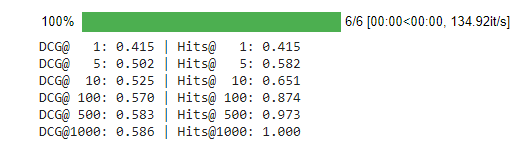

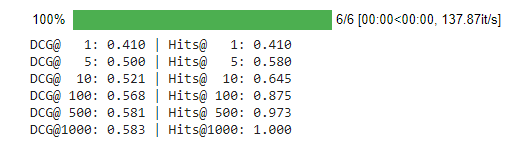

2) Для обученных нами эмбеддингов нормализация не дала улучшений.

3) Обученные нами эмбеддинги дают качество выше, по-видимому из-за того что обучались на нашем же тексте.

4) Плохое качество решения задачи получилось на эмбеддингах, полученных в результате обучения на других текстах.

5) Также можно увеличить число эмбеддингов и удалить часто встречающиеся слова, которые не несут информации. 